In [117]:
#Using the x-y view to detect the largest segement - as the images have always been taken with the cortex facing up.

#Importing required modules
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import imutils
import math 
import cv2
import csv


#To plot in jupyter 
%matplotlib inline

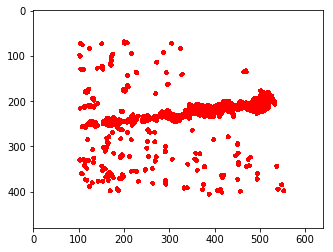

In [118]:
#Reading in xy image 
original_image = cv2.imread('xy.png')
#Flipping the y axis as the default y axis has the 0 on top 
original_image = original_image[::-1,:,:]

#Displaying xy image, channel doesn't matter
plt.imshow(original_image)
plt.show() 

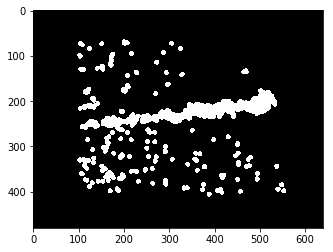

In [119]:
#Converting image to grayscale
original_image_gray = cv2.cvtColor(original_image,cv2.COLOR_BGR2GRAY)
plt.imshow(original_image_gray, cmap="gray")

#Switching black and white, to input to contour detection function
img = cv2.subtract(255, original_image_gray) 
plt.imshow(img, cmap="gray")
plt.show()

In [120]:
#https://www.youtube.com/watch?v=IG3UkAqHnQI
#Finding contours
_,contours,_ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#Printing the number of contours found 
print(len(contours))

95


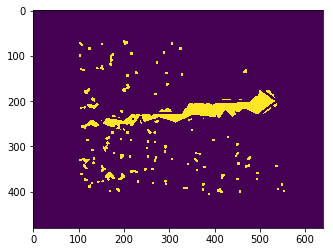

In [121]:
#Approximating a polygon for each contour, and drawing them out 
for cnt in contours:
    #epsilon - is the maximum distance from contour to approximated contour - set as 1% 
    #epsilon = error_rate + actual_arc_length
    
    epsilon = 0.01*cv2.arcLength(cnt, True)
    
    #Use approxPolyDP to approximate a polygon to each contour
    
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    
    #Draw the approximated contours around the image using drawContours
    img = cv2.drawContours(img, [approx], 0, (0, 255, 255), 3) 
    
plt.imshow(img)
plt.show()

In [122]:
#Finding center, area and perimeter of the polygons using Hu moments
area = list(); perimeter = list()
for cnt in contours:
    M = cv2.moments(cnt)

    #Center
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    center = (cx, cy)
    
    #Area
    area.append(cv2.contourArea(cnt))
    
    #Perimeter
    perimeter.append(cv2.arcLength(cnt, True))

#Finding the index of the largest polygon
maxArea = max(area)
maxPerimeter = max(perimeter)

area = np.array(area, dtype = float)
perimeter = np.array(perimeter, dtype = float)

MaxAreaPos = np.where(area == maxArea)
p = MaxAreaPos[0][0]
MaxPerimeterPos = np.where(perimeter == maxPerimeter)

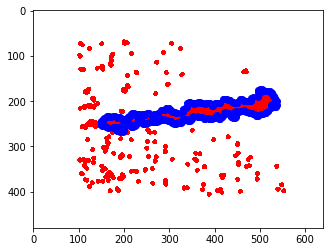

In [123]:
#Vizualizing the coordinates of the largest contour in blue
for i in range(0, len(contours[p])):
    plt.scatter(contours[p][i][0][0], contours[p][i][0][1], c = "b")
plt.imshow(original_image)

In [124]:
#Reading in original points after clustering 
X = list(); Y = list(); Z = list()
with open ('ClusteredC1.csv', 'r') as csv_file:
    csv_reader = csv.reader (csv_file)
    #Iterating through contents in the file
    for line in csv_reader:
        #each line has X,Y,Z,S
        X.append(line[0])
        Y.append(line[1])
        Z.append(line[2])
        
with open ('ClusteredC2.csv', 'r') as csv_file:
    csv_reader = csv.reader (csv_file)
    #Iterating through contents in the file
    for line in csv_reader:
        #each line has X,Y,Z,S
        X.append(line[0])
        Y.append(line[1])
        Z.append(line[2])
        

X = np.array(X); Y = np.array(Y); Z = np.array(Z)
X = X.astype(float); Y = Y.astype(float); Z = Z.astype(float)

#Making lists of x,y coordinates of contours 

XContours = list(); YContours = list()
for cnt in contours:
    for i in cnt:
        XContours.append(i[0][0])
        YContours.append(i[0][1]) 

In [188]:
#Finding the transformation to make the picture and scatter coordinates correspond

#Finding the max and min x and y for scatter and picture 
minXScatter = 10000; maxXScatter = 0; minYScatter = 10000; maxYScatter = 0
minXPicture = 10000; maxXPicture = 0; minYPicture = 10000; maxYPicture = 0

#Finding the positions of the corner points to move picture appropriately 
minXScatterPos = 0; minYScatterPos = 0
minXPicturePos = 0; minYPicturePos = 0

pos = -1
for x,y in zip(X,Y):
    pos = pos + 1
    if (x < minXScatter):
        minXScatter = x
        minXScatterPos = pos
    if (x > maxXScatter):
        maxXScatter = x
    if (y < minYScatter):
        minYScatter = y
        minYScatterPos = pos
    if (y > maxYScatter):
        maxYScatter = y

#Finding x and y spread for scatter points
XScatterDiff = maxXScatter - minXScatter
YScatterDiff = maxYScatter - minYScatter

pos = -1
for x,y in zip(XContours,YContours):
    pos = pos +1 
    if (x < minXPicture):
        minXPicture = x
        minXPicturePos = pos
    if (x > maxXPicture):
        maxXPicture = x
    if (y < minYPicture):
        minYPicture = y
        minYPicturePos = pos
    if (y > maxYPicture):
        maxYPicture = y

#Finding x and y spread for picture points
XPictureDiff = maxXPicture - minXPicture
YPictureDiff = maxYPicture - minYPicture

#Calculating scaling factor - dividing picture points by this 
Xfactor = XPictureDiff/XScatterDiff
Yfactor = YPictureDiff/YScatterDiff

#Repositioning the picture - take the negative of this 
Xmove = (XContours[minXPicturePos] - X[minXScatterPos])/Xfactor
Ymove = (YContours[minYPicturePos] - Y[minYScatterPos])/Yfactor

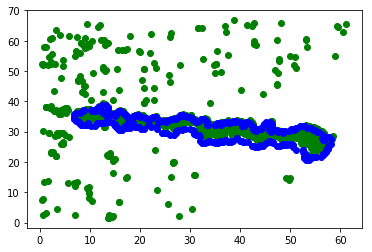

In [192]:
plt.scatter(X,Y, c='g')

#positive - left 
#positive - down 

Xcorrected = list(); Ycorrected = list()

#Checking if the repositioning is right 
for i in range(0, len(contours[p])):
    
    if(Xmove > 0):
        x = contours[p][i][0][0]/Xfactor - Xmove
        Xcorrected.append(x)
    else:
        x = contours[p][i][0][0]/Xfactor + Xmove
        Xcorrected.append(x)
    if(Ymove > 0):
        y = contours[p][i][0][1]/Yfactor - Ymove
        Ycorrected.append(y)
    else:
        y = contours[p][i][0][1]/Yfactor + Ymove
        Ycorrected.append(y)

plt.scatter(Xcorrected, Ycorrected, c = "b")

In [194]:
#Finding the x,y range of the aggregate 

maxX = max(Xcorrected)
minX = min(Xcorrected)
maxY = max(Ycorrected)
minY = min(Ycorrected)

print(minX); print(maxX)
print(minY); print(maxY)

6.79869319349506
58.187967482055925
20.635133336841665
38.718566189650915


In [ ]:
#Making two lists - within the xy range and outside and making a list of positions to find the z spread of the cortex
